# Podržano učenje s Scikit Learn bibliotekom. 

### Biblioteke

- [scikit-learn](http://scikit-learn.org/stable/)
- pandas
- matplotlib

Cilj današnje vježbe je naučiti koristiti osnovne funkcionalnosti scikit-learn biblioteke za treniranje modela podržanog strojnog učenja. Modeli koje ćemo obraditi su Linearna Regresija, $k$ najbližih susjeda, logistička regresija i Slučajne šume.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, auc, roc_curve, classification_report

# import seaborn as sns
%matplotlib inline


# Linearna regresija - Predviđanje prodaje iz cijene oglašavanja

## Podatci

In [2]:
data = pd.read_csv('data/Advertising.csv', index_col=0)
data


,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9
...,...,...,...,...
196,38.2,3.7,13.8,7.6
197,94.2,4.9,8.1,9.7
198,177.0,9.3,6.4,12.8
199,283.6,42.0,66.2,25.5



Koje su **značajke**?
- TV: dolari potrošeni na TV oglašavanje za jedan proizvod na određenom tržištu (u tisućama dolara)
- Radio: dolari potrošeni na oglašavanje na radiju
- Novine: dolari potrošeni na oglašavanje u novinama

Što je **izlaz**?
- Prodaja: prodaja jednog proizvoda na određenom tržištu (u tisućama jedinica) 

Vizualizacija odnosa između značajki i izlaza

<AxesSubplot:xlabel='newspaper', ylabel='sales'>

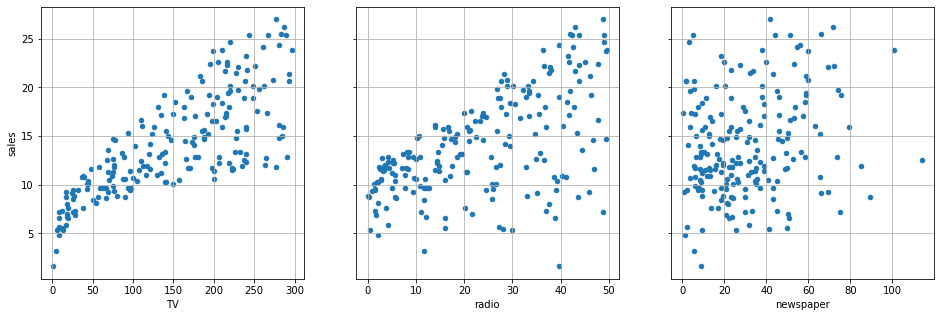

In [3]:
fig, axs = plt.subplots(1, 3, sharey=True)
data.plot(kind='scatter', x='TV', y='sales',
          ax=axs[0], figsize=(16, 5), grid=True)
data.plot(kind='scatter', x='radio', y='sales', ax=axs[1], grid=True)
data.plot(kind='scatter', x='newspaper', y='sales', ax=axs[2], grid=True)


## Procjena ("učenje") koeficijenata modela

Općenito govoreći, koeficijenti se procjenjuju korištenjem **metodom najmanjih kvadrata**, što znači da pronalazimo liniju (matematički) koja minimizira **zbroj kvadrata reziduala** (ili "zbroj grešaka na kvadrat"):

<img src="img/estimating_coefficients.png">

Pitanja:
- S koliko parametara je opisana ovakva funkcija?
- Što bi svaki od tih parametara pokazivao na ovoj slici?

## Učenje modela

Podijelimo prvo podatke na matricu značajki (X) i vektor razreda (y)

In [4]:
feature_cols = ['TV', 'radio', 'newspaper']
X = data[feature_cols]
y = data.sales

X.describe()

,TV,radio,newspaper
count,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000
std,85.854236,14.846809,21.778621
min,0.700000,0.000000,0.300000
25%,74.375000,9.975000,12.750000
50%,149.750000,22.900000,25.750000
75%,218.825000,36.525000,45.100000
max,296.400000,49.600000,114.000000


Dobro je provjeriti nedostaju li podatci u skupu. 

In [5]:
X.isna().sum(axis=0)

TV           0
radio        0
newspaper    0
dtype: int64

**Scikit-learn** pruža vrlo jednostavan način učenja modela

In [6]:
model = LinearRegression()  # create the model
model.fit(X, y)  # train it

LinearRegression()

Da vidimo kako izgleda formula modela

In [7]:
print(f"{model.intercept_:.3}", end="")
for coef, feature in zip(model.coef_, feature_cols):
    print(f" + {coef:.3} * {feature}", end="")

2.94 + 0.0458 * TV + 0.189 * radio + -0.00104 * newspaper


$$y = \beta_0 + \beta_1  \times TV + \beta_2  \times radio + \beta_3  \times newspaper$$
$$y = 2.94 + 0.0458 \times TV + 0.189  \times radio + -0.00104  \times newspaper$$


In [8]:
lr = LinearRegression()

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
y_pred = cross_val_predict(lr, X, y, cv=5)


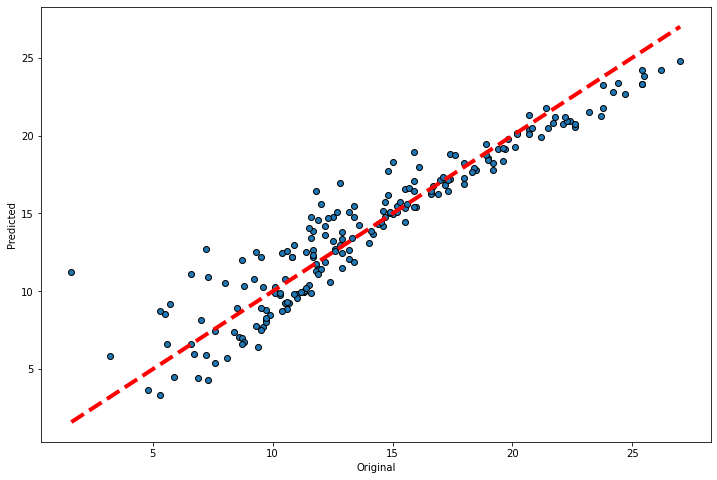

error = 3.0729465971002092


In [9]:

# Plot the results
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(y, y_pred, edgecolors=(0, 0, 0))
ax.plot([min(y), max(y)], [min(y), max(y)], 'r--', lw=4)
ax.set_xlabel('Original')
ax.set_ylabel('Predicted')
plt.show()

print(f"error = {mean_squared_error(y, y_pred)}")

Dodatne informacije o unakrsnoj validaciji - https://en.wikipedia.org/wiki/Cross-validation_(statistics)

## Regularizacija

U našem skupu podataka imamo samo 3 značajke, ali 200 zapisa, što je dovoljno za učenje dobrog linearnog modela. No što kad bi imali puno manje zapisa, recimo, 5?

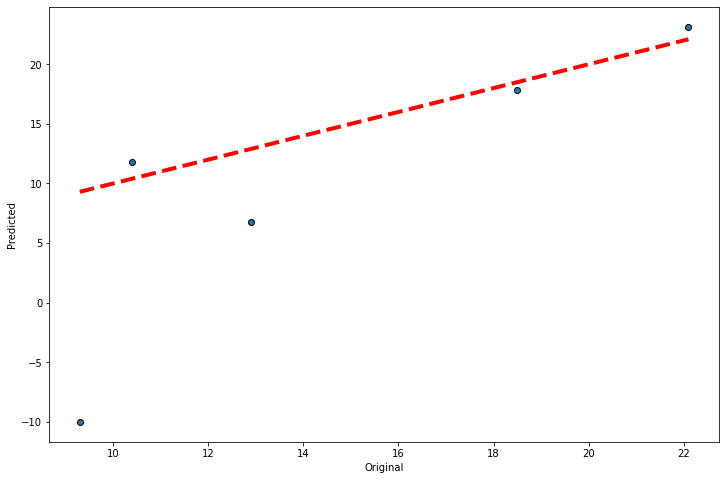

error = 82.77419262404145


In [10]:
N = 5
X_s = X[:N]
y_s = y[:N]

lr = LinearRegression()

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
y_pred = cross_val_predict(lr, X_s, y_s, cv=5)

# Plot the results
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(y_s, y_pred, edgecolors=(0, 0, 0))
ax.plot([min(y_s), max(y_s)], [min(y_s), max(y_s)], 'r--', lw=4)
ax.set_xlabel('Original')
ax.set_ylabel('Predicted')
plt.show()

print(f"error = {mean_squared_error(y_s, y_pred)}")


**Problem**: Model pamti zapise iz skupa za treniranje (prenaučenost).

**Rješenje**: Regularizacija

Regularizacija se odnosi na metode koje pomažu u smanjenju prenaučenosti. Pokušajmo koristiti Ridge Regresiju, koja kažnjava velike težine $\beta_i$ i prisiljava ih da budu manjih magnituda. Time se smanjuje složenost modela.

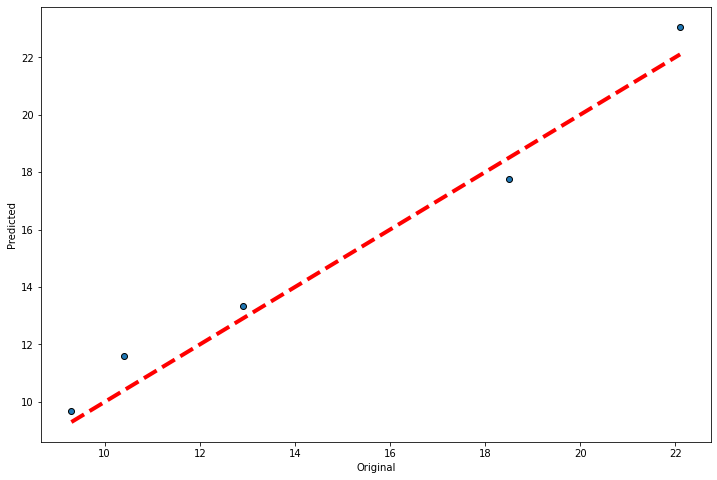

error = 0.6442462580572375


In [11]:
ridge = Ridge(alpha=6)

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
y_pred = cross_val_predict(ridge, X_s, y_s, cv=5)

# Plot the results
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(y_s, y_pred, edgecolors=(0, 0, 0))
ax.plot([min(y_s), max(y_s)], [min(y_s), max(y_s)], 'r--', lw=4)
ax.set_xlabel('Original')
ax.set_ylabel('Predicted')
plt.show()

print(f"error = {mean_squared_error(y_s, y_pred)}")


# Logistička regresija - Predviđanje vjerojatnosti preživljavanja titanika

Za to ćemo koristiti podatke dostupne na _Encyclopedia Titanica_. 

## Podatci

In [12]:
data = pd.read_excel('data/titanic.xls')
data

,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S
1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S
2,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S
3,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S
4,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S
...,...,...,...,...,...,...,...,...,...,...
1304,0,"Zabour, Miss. Hileni",female,14.5000,1,0,2665,14.4542,NaN,C
1305,0,"Zabour, Miss. Thamine",female,NaN,1,0,2665,14.4542,NaN,C
1306,0,"Zakarian, Mr. Mapriededer",male,26.5000,0,0,2656,7.2250,NaN,C
1307,0,"Zakarian, Mr. Ortin",male,27.0000,0,0,2670,7.2250,NaN,C


Koje su **značajke**?
- name: Ime putnika
- sex: muški ili ženski
- age: Starost u godinama
- sibsp: broj braće i sestara / supružnika na Titanicu
- parch: broj roditelja/djece na Titanicu
- ticket: broj ulaznice
- fare: cijena karte
- cabin: broj kabine
- embarked: Luka ukrcaja

Kakav je **odgovor**?
- preživio: je li putnik preživio katastrofu ili ne

In [13]:
dead = data[data['survived'] == 0]
survived = data[data['survived'] == 1]

print("Survived {0}, Dead {1}".format(len(survived), len(dead)))
print("Survived {:.2%}".format(len(survived)/len(data)))

Survived 500, Dead 809
Survived 38.20%


Za potrebe ove vježbe uzeti ćemo samo neke značajke i pretpostaviti da ostale nisu prediktivne.

In [14]:
feature_cols = ['sex', 'age', 'sibsp', 'parch', 'fare']
X = pd.get_dummies(data[feature_cols])
y = data.survived


In [15]:
X.isna().sum(axis=0)

age           263
sibsp           0
parch           0
fare            1
sex_female      0
sex_male        0
dtype: int64

Pokušajmo popraviti podatke osnovnom metodom imputacije: zamjenjujući nedostajuće vrijednosti srednjom vrijednosti.

Više informacija: https://en.wikipedia.org/wiki/Imputation_(statistics)

In [16]:
X = X.fillna(X.mean())
X.isna().sum(axis=0)


age           0
sibsp         0
parch         0
fare          0
sex_female    0
sex_male      0
dtype: int64

Treniranje modela i ispis izvještaja

In [17]:
logistic = LogisticRegression()
y_pred = cross_val_predict(logistic, X,  y, cv=10)

print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.84      0.82       809
           1       0.72      0.68      0.70       500

    accuracy                           0.77      1309
   macro avg       0.76      0.76      0.76      1309
weighted avg       0.77      0.77      0.77      1309



Ako logistička regresija klasifikator, zašto se onda zove regresija?

Logistička regresija koristi prag vjerojatnosti za odlučivanje kojoj klasi dodijeliti predviđanje. U nekim slučajevima nas zanima kako se model ponaša na različitim razinama ovog praga.

Pogledajmo ROC krivulju!
https://en.wikipedia.org/wiki/Receiver_operating_characteristic

Text(0.5, 1.0, 'ROC Curve - Area = 0.80295')

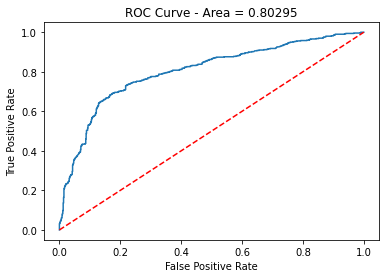

In [18]:
# Predict the probabilities with a cross validationn
y_pred_proba = cross_val_predict(logistic, X, y, cv=10, method="predict_proba")
# Compute the False Positive Rate and True Positive Rate
fpr, tpr, _ = roc_curve(y, y_pred_proba[:, 1])
# Compute the area under the fpt-tpf curve
auc_score = auc(fpr, tpr)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Area = {:.5f}".format(auc_score))

In [19]:
logistic.fit(X, y)

LogisticRegression()

In [20]:
test = pd.DataFrame([
    [25, 0, 0, 100, 0, 1], # 25 year old man
    [25, 0, 0, 100, 1, 0], # 25 year old woman
], columns=X.columns)

logistic.predict(test)

array([0, 1])

In [21]:
logistic.predict_proba(test)

array([[0.5528599 , 0.4471401 ],
       [0.09632673, 0.90367327]])

# Slučajna šuma - podatci s Titanika

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

number_trees = [n for n in range(1, 21)]

accuracy_scores = []
f1_scores = []


for nt in number_trees:
    clf = RandomForestClassifier(max_depth=5, random_state=0, n_estimators=nt)
    clf.fit(X, y)
    y_pred = cross_val_predict(clf, X, y, cv=5)

    accuracy_scores.append(accuracy_score(y, y_pred))
    f1_scores.append(f1_score(y, y_pred))

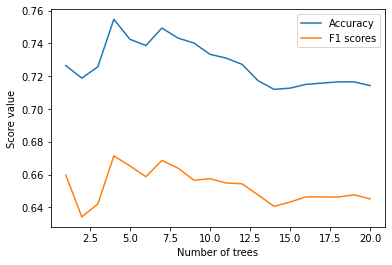

In [23]:
fig, ax = plt.subplots(1, figsize=(6, 4))

ax.plot(number_trees, accuracy_scores, label="Accuracy")
ax.plot(number_trees, f1_scores, label="F1 scores")

ax.set_ylabel("Score value")
ax.set_xlabel("Number of trees")
ax.legend()


---------

# Kratki pregled rada K-NN modela

Prvo je potrebno generirati kopleksne oblike kako bi pokazali rad k-NN modela.

Text(0.5, 1.0, 'Circles')

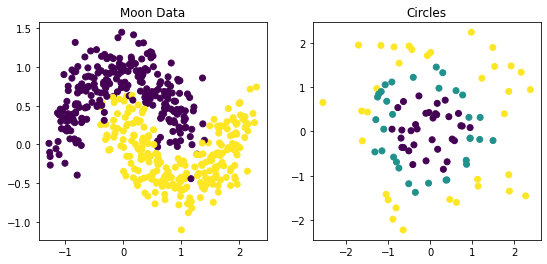

In [24]:
from sklearn.datasets import make_moons, make_gaussian_quantiles
from sklearn.model_selection import train_test_split

X_moons, y_moons = make_moons(500, noise=0.2, random_state=0)
X_circles, y_circles = make_gaussian_quantiles(n_samples=100, random_state=0)


fig, axs = plt.subplots(1, 2, figsize=(9,4))

axs[0].scatter(X_moons[:,0], X_moons[:,1], c=y_moons)
axs[0].set_title('Moon Data')

axs[1].scatter(X_circles[:,0], X_circles[:,1], c=y_circles)
axs[1].set_title('Circles')

In [25]:
# Plotting helper 
# Source: https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
from matplotlib.colors import ListedColormap

def plot_prediction(model, X, y, ax, K):
    # step size in the mesh
    h = .02
    # Create color maps
    cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
    cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')

    # Plot also the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_title("K = {}".format(K))

Stvaranje modela sa k=1 i k=15

In [26]:
# K = 1
clf_moons_1 = KNeighborsClassifier(1)
clf_moons_1.fit(X_moons, y_moons)
clf_circles_1 = KNeighborsClassifier(1)
clf_circles_1.fit(X_circles, y_circles)

# K = 15
clf_moons_15 = KNeighborsClassifier(15)
clf_moons_15.fit(X_moons, y_moons)
clf_circles_15 = KNeighborsClassifier(15)
clf_circles_15.fit(X_circles, y_circles)

KNeighborsClassifier(n_neighbors=15)